This is the banchmarking of the network architecture 

In [1]:
from Medfl.LearningManager.utils import global_params

import sys
sys.path.append(global_params['base_url'])

import os
os.environ['PYTHONPATH'] = global_params['base_url']

In [2]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine,text

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim

## MedFL Imports 
## Network Manager Imports 
from Medfl.NetManager.node import Node
from Medfl.NetManager.network import Network
from Medfl.NetManager.dataset import DataSet
from Medfl.NetManager.flsetup import FLsetup

# flower imports 
import flwr as fl

## Learning Manager imports 
from Medfl.LearningManager.dynamicModal import DynamicModel
from Medfl.LearningManager.model import Model
from Medfl.LearningManager.strategy import Strategy
from Medfl.LearningManager.server import *
from Medfl.LearningManager.flpipeline import *
from Medfl.LearningManager.plot import AccuracyLossPlotter



# Utils
from Medfl.LearningManager.utils import *


2024-02-26 13:28:23.105323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# DB Creation 
!python3 ../../../scripts/create_db.py

# clearn DB 
# empty_db()

In [4]:
# Create a nest work "Net_1"
Net_1 = Network(name="manual_network")
Net_1.create_network()

Net_1.name

/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/pandas/io/sql.py:1761: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  return insp.has_table(name, schema or self.meta.schema)


'manual_network'

In [5]:
# Create a MasterDataSet from Net_1
Net_1.create_master_dataset()

# Check if the Network has a masterDataSet Table ( 1: Table exists ; 0: Table doesn't exist)
Net_1.mtable_exists

/home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/notebooks/data/masterDataSet/Mimic_train.csv


1

In [6]:
# auto FLsetup creation
autoFl  = FLsetup(name = "Flsetup_1", description = "The first fl setup",network = Net_1)
autoFl.create()

# List all setups 
FLsetup.list_allsetups()

,FLsetupId,name,description,creation_date,NetId,column_name
0,1,Flsetup_1,The first fl setup,2024-02-26 13:28:40,1,None


# Configuration_1: A Manual network with 5 Nodes 
This network contains 5 nodes (3 Train nodes and 2 test nodes)

In [7]:
# Create 5 nodes 
hospital_1,hospital_2,hospital_3, hospital_4 , hospital_5 = Node(name = "hospital_1", train = 1),Node(name = "hospital_2", train = 1),Node(name = "hospital_3", train = 1),Node(name = "hospital_4", train = 0),Node(name = "hospital_5", train = 0)

In [8]:
# Assign the 3 nodes to the man_network 
Net_1.add_node(hospital_1)
Net_1.add_node(hospital_2)
Net_1.add_node(hospital_3) 
Net_1.add_node(hospital_4)
Net_1.add_node(hospital_5) 

In [9]:
# List all created nodes on the db 
Node.list_allnodes()

,NodeId,NodeName,train,NetId
0,1,hospital_1,1,1
1,2,hospital_2,1,1
2,3,hospital_3,1,1
3,4,hospital_4,0,1
4,5,hospital_5,0,1


In [10]:
# Define the path of the files 
# Train Data 
Ds_1 = global_params['base_url']+ '/notebooks/data/config_1/part_1.csv'
Ds_2 = global_params['base_url']+ '/notebooks/data/config_1/part_2.csv'
Ds_3 = global_params['base_url']+ '/notebooks/data/config_1/part_3.csv'

# pload the DataSets 
hospital_1.upload_dataset( dataset_name = "hospital_1_dataset" , path_to_csv=Ds_1  )
hospital_2.upload_dataset( dataset_name = "hospital_2_dataset" , path_to_csv=Ds_2)
hospital_3.upload_dataset( dataset_name = "hospital_3_dataset" , path_to_csv=Ds_3 )

# Test Data 
test_1 = global_params['base_url']+ '/notebooks/data/config_1/test_1.csv'
test_2 = global_params['base_url']+ '/notebooks/data/config_1/test_2.csv'

hospital_4.upload_dataset( dataset_name = "hospital_2_dataset" , path_to_csv=test_1)
hospital_5.upload_dataset( dataset_name = "hospital_3_dataset" , path_to_csv=test_2 )




In [11]:
# Create FLDataSet
fl_dataset = autoFl.create_federated_dataset(
    output="deceased", 
    fit_encode=[], 
    to_drop=[ "deceased" ]
    )

In [12]:
fl_dataset.size

17

In [13]:
# Creating a DynamicModel instance
dynamic_model = DynamicModel()

# Creating a specific model dynamically using DynamicModel
specific_model = dynamic_model.create_model(model_type='Logistic Regressor', params_dict={"input_dim": 17, "output_dim": 1})

# Pass the specific_model to the Model class
optimizer = optim.SGD(specific_model.parameters(), lr=0.0001)
criterion = nn.BCELoss()


# Creating a new Model instance using the specific model created by DynamicModel
global_model = Model(specific_model, optimizer, criterion)

# The modal to be passed to the server
global_model.get_parameters()

[array([[ 0.07204353,  0.15276437,  0.03655647, -0.15037553,  0.04332963,
          0.00477811,  0.1916973 ,  0.10060839,  0.19355342,  0.00492874,
          0.23018296, -0.099392  ,  0.06859427,  0.06694663,  0.16906196,
          0.10017522, -0.09915686]], dtype=float32),
 array([0.18184325], dtype=float32)]

In [14]:
# Define the neural network model using PyTorch
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

In [15]:
# Load the pretrained model
model = Model.load_model("../../../notebooks/.ipynb_checkpoints/trainedModels/eicu_binary_classifier.pth")


# Pass the specific_model to the Model class
optimizer = optim.SGD(model.parameters(), lr=0.0001)
# Define loss function and optimizer
pos_weight = torch.tensor([7 ])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Creating a new Model instance using the specific model created by DynamicModel
global_model = Model(model, optimizer, criterion)

# Get the initial params of the model 
init_params = global_model.get_parameters() ; 

print(model)

BinaryClassifier(
  (fc1): Linear(in_features=17, out_features=64, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [16]:
# Create the strategy
fed_avg = Strategy("FedAvg", 
                   fraction_fit = 1.0 ,
                   fraction_evaluate = 1.0,
                   min_fit_clients = 2,
                   min_evaluate_clients = 2,
                   min_available_clients = 2 , 
                   initial_parameters=global_model.get_parameters())

In [17]:
# Create The server 
server = FlowerServer(global_model, strategy = fed_avg, num_rounds = 10,
                       num_clients  = len(fl_dataset.trainloaders), 
                       fed_dataset = fl_dataset,diff_privacy = False ,
                       # You can change the resources alocated for each client based on your machine 
                       client_resources={'num_cpus': 1.0, 'num_gpus': 0.0}
                       )

In [18]:
# Create the pipeline 
ppl_1 = FLpipeline( name ="the first fl_pipeline",description = "this is our first FL pipeline",
                   server = server)

In [19]:
# Run the Traning of the model
history = ppl_1.server.run()

INFO flwr 2024-02-26 13:29:15,200 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
02/26/2024 13:29:15:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-26 13:29:17,368	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-26 13:29:19,719 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 41780347700.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'CPU': 24.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0}
02/26/2024 13:29:19:INFO:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 41780347700.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'CPU': 24.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0}
INFO flwr 2024-02-26 13:29:19,719 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
02/26/2024 13:29:19:INFO:Opt

Server-side evaluation loss 0.04121578443381521 / accuracy 0.88125


(DefaultActor pid=667834) /home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/Medfl/LearningManager/utils.py:19: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
(DefaultActor pid=667834)   global_yaml_path = pkg_resources.resource_filename(__name__, "../../global_params.yaml")
(DefaultActor pid=667834) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=667834)   warnings.warn(
(DefaultActor pid=667834) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.

(DefaultActor pid=667834) [Client 0] fit, config: {}
(DefaultActor pid=667834) 	Train Epoch: 0 	Loss: 1.313356 Acc@1: 68.437500
(DefaultActor pid=667834) 	Train Epoch: 0 	Loss: 1.407649 Acc@1: 59.531250
(DefaultActor pid=667834) 	Train Epoch: 0 	Loss: 1.389007 Acc@1: 53.333333
(DefaultActor pid=667834) 	Train Epoch: 0 	Loss: 1.412817 Acc@1: 54.375000
(DefaultActor pid=667834) 	Train Epoch: 1 	Loss: 1.313356 Acc@1: 68.437500
(DefaultActor pid=667834) 	Train Epoch: 1 	Loss: 1.407644 Acc@1: 58.906250
(DefaultActor pid=667834) 	Train Epoch: 1 	Loss: 1.391127 Acc@1: 44.583333
(DefaultActor pid=667834) 	Train Epoch: 1 	Loss: 1.414407 Acc@1: 49.765625
(DefaultActor pid=667834) 	Train Epoch: 2 	Loss: 1.313356 Acc@1: 68.437500
(DefaultActor pid=667834) 	Train Epoch: 2 	Loss: 1.412768 Acc@1: 55.156250
(DefaultActor pid=667834) 	Train Epoch: 2 	Loss: 1.391774 Acc@1: 53.229167
(DefaultActor pid=667834) 	Train Epoch: 2 	Loss: 1.416970 Acc@1: 54.296875
(DefaultActor pid=667834) 	Train Epoch: 3 	Loss

DEBUG flwr 2024-02-26 13:29:32,505 | server.py:236 | fit_round 1 received 3 results and 0 failures
02/26/2024 13:29:32:DEBUG:fit_round 1 received 3 results and 0 failures


(DefaultActor pid=667833) [Client 2] fit, config: {} [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(DefaultActor pid=667834) epsilon of client 0 : eps = 0
(DefaultActor pid=667832) 	Train Epoch: 197 	Loss: 1.492279 Acc@1: 49.687500 [repeated 2341x across cluster]


WARNING flwr 2024-02-26 13:29:32,514 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
02/26/2024 13:29:32:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-02-26 13:29:32,524 | server.py:125 | fit progress: (1, 0.04121578443381521, {'accuracy': 0.88125}, 12.778430098900571)
02/26/2024 13:29:32:INFO:fit progress: (1, 0.04121578443381521, {'accuracy': 0.88125}, 12.778430098900571)
DEBUG flwr 2024-02-26 13:29:32,525 | server.py:173 | evaluate_round 1: strategy sampled 3 clients (out of 3)
02/26/2024 13:29:32:DEBUG:evaluate_round 1: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-26 13:29:32,568 | server.py:187 | evaluate_round 1 received 3 results and 0 failures
02/26/2024 13:29:32:DEBUG:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2024-02-26 13:29:32,569 | fedavg.py:281 | No evaluate_metrics_aggregation_fn provided
02/26/2024 13:29:32:WARNING:No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-02-26 13:29:32,570 | server.py:222 | fi

Server-side evaluation loss 0.04121578443381521 / accuracy 0.88125
(DefaultActor pid=667833) [Client 1] evaluate, config: {}
(DefaultActor pid=667832) 
(DefaultActor pid=667834) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=667833) epsilon of client 2 : eps = 0 [repeated 2x across cluster]
(DefaultActor pid=667832) 	Train Epoch: 193 	Loss: 1.411790 Acc@1: 46.093750 [repeated 2327x across cluster]


DEBUG flwr 2024-02-26 13:29:37,657 | server.py:236 | fit_round 2 received 3 results and 0 failures
02/26/2024 13:29:37:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-02-26 13:29:37,671 | server.py:125 | fit progress: (2, 0.04121578443381521, {'accuracy': 0.88125}, 17.92485175281763)
02/26/2024 13:29:37:INFO:fit progress: (2, 0.04121578443381521, {'accuracy': 0.88125}, 17.92485175281763)
DEBUG flwr 2024-02-26 13:29:37,672 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
02/26/2024 13:29:37:DEBUG:evaluate_round 2: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-26 13:29:37,713 | server.py:187 | evaluate_round 2 received 3 results and 0 failures
02/26/2024 13:29:37:DEBUG:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2024-02-26 13:29:37,714 | server.py:222 | fit_round 3: strategy sampled 3 clients (out of 3)
02/26/2024 13:29:37:DEBUG:fit_round 3: strategy sampled 3 clients (out of 3)


(DefaultActor pid=667834) [Client 0] evaluate, config: {} [repeated 2x across cluster]
Server-side evaluation loss 0.04121578443381521 / accuracy 0.88125


(DefaultActor pid=667833) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 3x across cluster]
(DefaultActor pid=667833)   warnings.warn( [repeated 3x across cluster]
(DefaultActor pid=667833) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across cluster]
(DefaultActor pid=667833)   client = check_clientfn_

(DefaultActor pid=667834) [Client 0] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=667834) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=667832) 	Train Epoch: 182 	Loss: 1.391150 Acc@1: 51.406250 [repeated 2279x across cluster]
(DefaultActor pid=667834) [Client 1] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-02-26 13:29:43,077 | server.py:236 | fit_round 3 received 3 results and 0 failures
02/26/2024 13:29:43:DEBUG:fit_round 3 received 3 results and 0 failures
INFO flwr 2024-02-26 13:29:43,085 | server.py:125 | fit progress: (3, 0.04063870136936506, {'accuracy': 0.8875}, 23.3389777939301)
02/26/2024 13:29:43:INFO:fit progress: (3, 0.04063870136936506, {'accuracy': 0.8875}, 23.3389777939301)
DEBUG flwr 2024-02-26 13:29:43,086 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
02/26/2024 13:29:43:DEBUG:evaluate_round 3: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-26 13:29:43,117 | server.py:187 | evaluate_round 3 received 3 results and 0 failures
02/26/2024 13:29:43:DEBUG:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2024-02-26 13:29:43,119 | server.py:222 | fit_round 4: strategy sampled 3 clients (out of 3)
02/26/2024 13:29:43:DEBUG:fit_round 4: strategy sampled 3 clients (out of 3)
(DefaultActor pid=667834) /home/local/USH

Server-side evaluation loss 0.04063870136936506 / accuracy 0.8875
(DefaultActor pid=667833) [Client 0] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=667833) epsilon of client 1 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=667832) 	Train Epoch: 172 	Loss: 1.414825 Acc@1: 47.343750 [repeated 2286x across cluster]
(DefaultActor pid=667834) [Client 2] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-02-26 13:29:48,319 | server.py:236 | fit_round 4 received 3 results and 0 failures
02/26/2024 13:29:48:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-02-26 13:29:48,329 | server.py:125 | fit progress: (4, 0.04063870136936506, {'accuracy': 0.8875}, 28.582920134998858)
02/26/2024 13:29:48:INFO:fit progress: (4, 0.04063870136936506, {'accuracy': 0.8875}, 28.582920134998858)
DEBUG flwr 2024-02-26 13:29:48,329 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
02/26/2024 13:29:48:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-26 13:29:48,367 | server.py:187 | evaluate_round 4 received 3 results and 0 failures
02/26/2024 13:29:48:DEBUG:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2024-02-26 13:29:48,368 | server.py:222 | fit_round 5: strategy sampled 3 clients (out of 3)
02/26/2024 13:29:48:DEBUG:fit_round 5: strategy sampled 3 clients (out of 3)
(DefaultActor pid=667833) /home/local

Server-side evaluation loss 0.04063870136936506 / accuracy 0.8875
(DefaultActor pid=667834) [Client 0] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=667834) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=667832) 	Train Epoch: 160 	Loss: 1.386294 Acc@1: 39.375000 [repeated 2271x across cluster]
(DefaultActor pid=667834) [Client 2] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-02-26 13:29:53,688 | server.py:236 | fit_round 5 received 3 results and 0 failures
02/26/2024 13:29:53:DEBUG:fit_round 5 received 3 results and 0 failures
INFO flwr 2024-02-26 13:29:53,696 | server.py:125 | fit progress: (5, 0.04063870136936506, {'accuracy': 0.8875}, 33.9499968548771)
02/26/2024 13:29:53:INFO:fit progress: (5, 0.04063870136936506, {'accuracy': 0.8875}, 33.9499968548771)
DEBUG flwr 2024-02-26 13:29:53,696 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
02/26/2024 13:29:53:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-26 13:29:53,725 | server.py:187 | evaluate_round 5 received 3 results and 0 failures
02/26/2024 13:29:53:DEBUG:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2024-02-26 13:29:53,726 | server.py:222 | fit_round 6: strategy sampled 3 clients (out of 3)
02/26/2024 13:29:53:DEBUG:fit_round 6: strategy sampled 3 clients (out of 3)
(DefaultActor pid=667833) /home/local/USH

Server-side evaluation loss 0.04063870136936506 / accuracy 0.8875
(DefaultActor pid=667834) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=667833) epsilon of client 1 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=667832) 	Train Epoch: 151 	Loss: 1.489093 Acc@1: 47.812500 [repeated 2264x across cluster]
(DefaultActor pid=667834) [Client 1] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-02-26 13:29:59,019 | server.py:236 | fit_round 6 received 3 results and 0 failures
02/26/2024 13:29:59:DEBUG:fit_round 6 received 3 results and 0 failures
INFO flwr 2024-02-26 13:29:59,031 | server.py:125 | fit progress: (6, 0.04063870136936506, {'accuracy': 0.8875}, 39.28578298492357)
02/26/2024 13:29:59:INFO:fit progress: (6, 0.04063870136936506, {'accuracy': 0.8875}, 39.28578298492357)
DEBUG flwr 2024-02-26 13:29:59,033 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
02/26/2024 13:29:59:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-26 13:29:59,066 | server.py:187 | evaluate_round 6 received 3 results and 0 failures
02/26/2024 13:29:59:DEBUG:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2024-02-26 13:29:59,067 | server.py:222 | fit_round 7: strategy sampled 3 clients (out of 3)
02/26/2024 13:29:59:DEBUG:fit_round 7: strategy sampled 3 clients (out of 3)
(DefaultActor pid=667832) /home/local/U

Server-side evaluation loss 0.04063870136936506 / accuracy 0.8875
(DefaultActor pid=667834) [Client 2] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=667834) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=667833) 	Train Epoch: 136 	Loss: 1.479256 Acc@1: 35.937500 [repeated 2270x across cluster]
(DefaultActor pid=667834) [Client 0] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-02-26 13:30:04,338 | server.py:236 | fit_round 7 received 3 results and 0 failures
02/26/2024 13:30:04:DEBUG:fit_round 7 received 3 results and 0 failures
INFO flwr 2024-02-26 13:30:04,352 | server.py:125 | fit progress: (7, 0.04063870136936506, {'accuracy': 0.8875}, 44.60624133399688)
02/26/2024 13:30:04:INFO:fit progress: (7, 0.04063870136936506, {'accuracy': 0.8875}, 44.60624133399688)
DEBUG flwr 2024-02-26 13:30:04,353 | server.py:173 | evaluate_round 7: strategy sampled 3 clients (out of 3)
02/26/2024 13:30:04:DEBUG:evaluate_round 7: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-26 13:30:04,390 | server.py:187 | evaluate_round 7 received 3 results and 0 failures
02/26/2024 13:30:04:DEBUG:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2024-02-26 13:30:04,391 | server.py:222 | fit_round 8: strategy sampled 3 clients (out of 3)
02/26/2024 13:30:04:DEBUG:fit_round 8: strategy sampled 3 clients (out of 3)
(DefaultActor pid=667833) /home/local/U

Server-side evaluation loss 0.04063870136936506 / accuracy 0.8875
(DefaultActor pid=667834) [Client 1] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=667833) epsilon of client 1 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=667832) 	Train Epoch: 129 	Loss: 1.319183 Acc@1: 42.500000 [repeated 2225x across cluster]
(DefaultActor pid=667834) [Client 1] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-02-26 13:30:09,745 | server.py:236 | fit_round 8 received 3 results and 0 failures
02/26/2024 13:30:09:DEBUG:fit_round 8 received 3 results and 0 failures
INFO flwr 2024-02-26 13:30:09,759 | server.py:125 | fit progress: (8, 0.04063870136936506, {'accuracy': 0.8875}, 50.01326123997569)
02/26/2024 13:30:09:INFO:fit progress: (8, 0.04063870136936506, {'accuracy': 0.8875}, 50.01326123997569)
DEBUG flwr 2024-02-26 13:30:09,760 | server.py:173 | evaluate_round 8: strategy sampled 3 clients (out of 3)
02/26/2024 13:30:09:DEBUG:evaluate_round 8: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-26 13:30:09,794 | server.py:187 | evaluate_round 8 received 3 results and 0 failures
02/26/2024 13:30:09:DEBUG:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2024-02-26 13:30:09,795 | server.py:222 | fit_round 9: strategy sampled 3 clients (out of 3)
02/26/2024 13:30:09:DEBUG:fit_round 9: strategy sampled 3 clients (out of 3)
(DefaultActor pid=667833) /home/local/U

Server-side evaluation loss 0.04063870136936506 / accuracy 0.8875
(DefaultActor pid=667834) [Client 1] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=667833) epsilon of client 2 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=667833) 	Train Epoch: 111 	Loss: 1.392426 Acc@1: 38.906250 [repeated 2251x across cluster]
(DefaultActor pid=667834) [Client 2] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-02-26 13:30:15,075 | server.py:236 | fit_round 9 received 3 results and 0 failures
02/26/2024 13:30:15:DEBUG:fit_round 9 received 3 results and 0 failures
INFO flwr 2024-02-26 13:30:15,083 | server.py:125 | fit progress: (9, 0.04063870136936506, {'accuracy': 0.8875}, 55.33749805903062)
02/26/2024 13:30:15:INFO:fit progress: (9, 0.04063870136936506, {'accuracy': 0.8875}, 55.33749805903062)
DEBUG flwr 2024-02-26 13:30:15,084 | server.py:173 | evaluate_round 9: strategy sampled 3 clients (out of 3)
02/26/2024 13:30:15:DEBUG:evaluate_round 9: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-26 13:30:15,115 | server.py:187 | evaluate_round 9 received 3 results and 0 failures
02/26/2024 13:30:15:DEBUG:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2024-02-26 13:30:15,117 | server.py:222 | fit_round 10: strategy sampled 3 clients (out of 3)
02/26/2024 13:30:15:DEBUG:fit_round 10: strategy sampled 3 clients (out of 3)
(DefaultActor pid=667833) /home/local

Server-side evaluation loss 0.04063870136936506 / accuracy 0.8875
(DefaultActor pid=667834) [Client 0] fit, config: {} [repeated 3x across cluster]
(DefaultActor pid=667834) epsilon of client 1 : eps = 0 [repeated 3x across cluster]
(DefaultActor pid=667832) 	Train Epoch: 100 	Loss: 1.369203 Acc@1: 30.546875 [repeated 2253x across cluster]
(DefaultActor pid=667834) [Client 1] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-02-26 13:30:20,360 | server.py:236 | fit_round 10 received 3 results and 0 failures
02/26/2024 13:30:20:DEBUG:fit_round 10 received 3 results and 0 failures
INFO flwr 2024-02-26 13:30:20,368 | server.py:125 | fit progress: (10, 0.04063870136936506, {'accuracy': 0.8875}, 60.62203573691659)
02/26/2024 13:30:20:INFO:fit progress: (10, 0.04063870136936506, {'accuracy': 0.8875}, 60.62203573691659)
DEBUG flwr 2024-02-26 13:30:20,369 | server.py:173 | evaluate_round 10: strategy sampled 3 clients (out of 3)
02/26/2024 13:30:20:DEBUG:evaluate_round 10: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-26 13:30:20,403 | server.py:187 | evaluate_round 10 received 3 results and 0 failures
02/26/2024 13:30:20:DEBUG:evaluate_round 10 received 3 results and 0 failures
INFO flwr 2024-02-26 13:30:20,404 | server.py:153 | FL finished in 60.65875138086267
02/26/2024 13:30:20:INFO:FL finished in 60.65875138086267
INFO flwr 2024-02-26 13:30:20,406 | app.py:226 | app_fit: losses_dist

Server-side evaluation loss 0.04063870136936506 / accuracy 0.8875


(DefaultActor pid=667832) [Client 1] evaluate, config: {}
(DefaultActor pid=667833) 	Train Epoch: 199 	Loss: 1.399041 Acc@1: 35.468750
(DefaultActor pid=667833) epsilon of client 1 : eps = 0


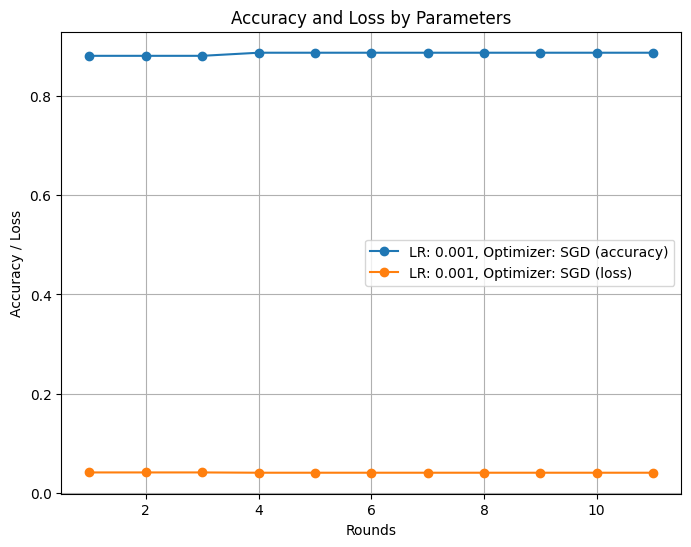

In [20]:
# Make some plots 
global_accuracy,global_loss = ppl_1.server.accuracies,ppl_1.server.losses
results_dict = {
    ('LR: 0.001, Optimizer: SGD', 'accuracy'): global_accuracy,
    ('LR: 0.001, Optimizer: SGD', 'loss'): global_loss
}
plotter = AccuracyLossPlotter(results_dict)

plotter.plot_accuracy_loss()

In [21]:
# Test the Modal on the Test nodes and store the results on the DB
ppl_1.auto_test()

[{'node_name': 'hospital_1',
  'classification_report': "{'confusion matrix': {'TP': 9, 'FP': 1, 'FN': 45, 'TN': 303}, 'Accuracy': 0.872, 'Sensitivity/Recall': 0.167, 'Specificity': 0.997, 'PPV/Precision': 0.9, 'NPV': 0.871, 'F1-score': 0.281, 'False positive rate': 0.003, 'True positive rate': 0.167}"},
 {'node_name': 'hospital_2',
  'classification_report': "{'confusion matrix': {'TP': 6, 'FP': 4, 'FN': 58, 'TN': 290}, 'Accuracy': 0.827, 'Sensitivity/Recall': 0.094, 'Specificity': 0.986, 'PPV/Precision': 0.6, 'NPV': 0.833, 'F1-score': 0.162, 'False positive rate': 0.014, 'True positive rate': 0.094}"},
 {'node_name': 'hospital_3',
  'classification_report': "{'confusion matrix': {'TP': 2, 'FP': 3, 'FN': 57, 'TN': 297}, 'Accuracy': 0.833, 'Sensitivity/Recall': 0.034, 'Specificity': 0.99, 'PPV/Precision': 0.4, 'NPV': 0.839, 'F1-score': 0.062, 'False positive rate': 0.01, 'True positive rate': 0.034}"},
 {'node_name': 'hospital_4',
  'classification_report': "{'confusion matrix': {'TP':

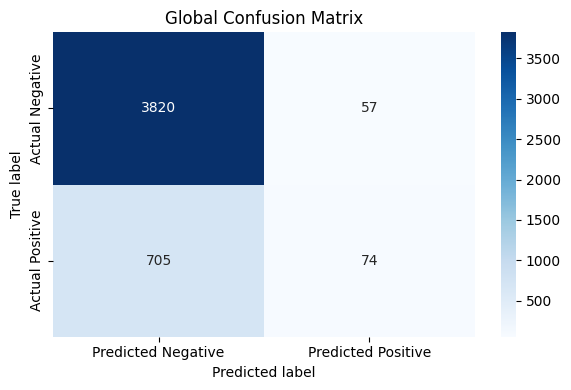

In [22]:
# Plot the Global confusion Matrix of the pipiline "the first fl_pipeline"
AccuracyLossPlotter.plot_global_confusion_matrix(pipeline_name="the first fl_pipeline")

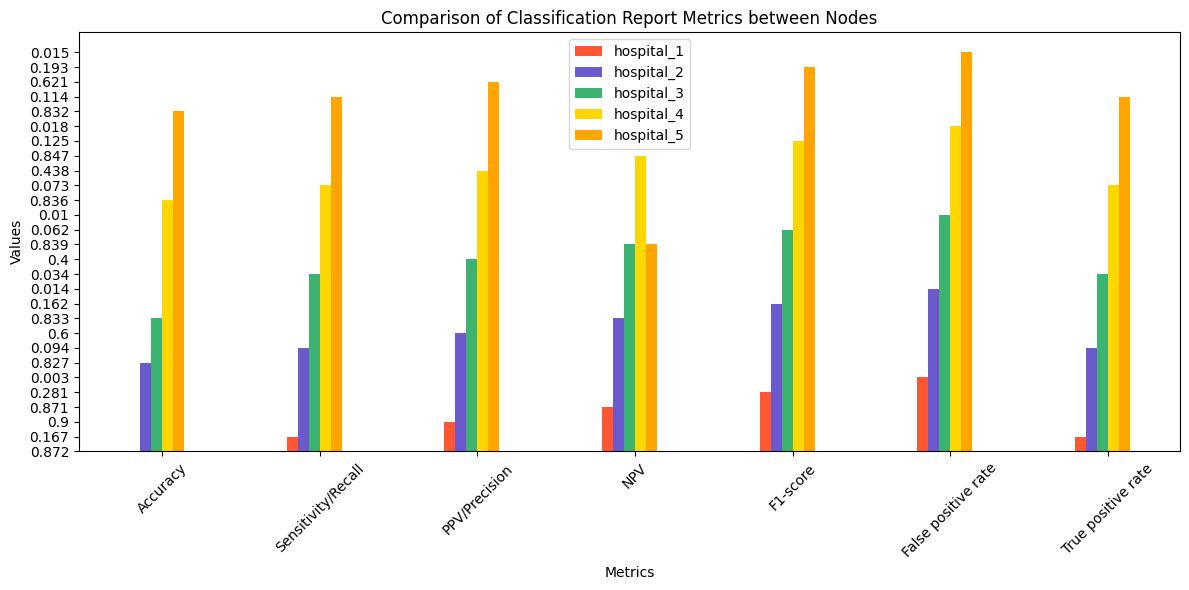

In [23]:
AccuracyLossPlotter.plot_classification_report(pipeline_name="the first fl_pipeline")